# JWST NIRCam RGB Image Creation

This notebook creates RGB composite images from JWST NIRCam observations in two filters:
- **F200W** (2.0 μm) - Short wavelength, mapped to **blue**
- **F322W2** (3.2 μm) - Long wavelength, mapped to **red**

The notebook produces:
1. **Full field-of-view RGB image** showing the entire NIRCam observation
2. **Zoomed RGB image** centered on a target of interest with custom overlays

---

## Step 1: Import Required Libraries

In [1]:
# Core scientific libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Astronomy-specific libraries
from astropy.io import fits
from astropy.wcs import WCS
from astropy.wcs.utils import proj_plane_pixel_scales
from astropy.visualization import make_lupton_rgb, ZScaleInterval

# JWST data models (if using jwst package)
try:
    from jwst import datamodels
    USING_DATAMODELS = True
except ImportError:
    print("jwst.datamodels not available, will use astropy.io.fits instead")
    USING_DATAMODELS = False

# Set plot style
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 11

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


## Step 2: Configuration - Set Your File Paths and Target

**USER INPUT REQUIRED:** Update the paths to your FITS files and target coordinates below.

In [4]:
# ============================================================================
# FILE PATHS
# ============================================================================

# Directory containing your i2d (stage 3) FITS files
i2d_dir = '../data/06779/i2d'

# FITS file names
f200w_filename = '06779001_sw_F200W_i2d.fits'
f322w2_filename = '06779001_lw_F322W2_i2d.fits'

# Output directory for saving RGB images
output_dir = 'data/06779/i2d'

# ============================================================================
# TARGET COORDINATES (Source of Interest)
# ============================================================================

# Sexagesimal coordinates (RA in hours, Dec in degrees)
ra_h = 12
ra_m = 11
ra_s = 59.31

dec_deg = 11
dec_m = 48
dec_s = 46.80

# Convert to decimal degrees
target_ra = (ra_h + ra_m / 60 + ra_s / 3600) * 15  # RA: hours → degrees
target_dec = dec_deg + dec_m / 60 + dec_s / 3600   # Dec: already in degrees

# ============================================================================
# ZOOM IMAGE PARAMETERS
# ============================================================================

# Size of the zoomed region around the target (in arcseconds)
zoom_region_size = 10.0  # arcsec (will create 10"×10" cutout)

# Size of the box/aperture to overlay on zoomed image (in arcseconds)
overlay_box_size = 3.0  # arcsec (e.g., galaxy size or extraction aperture)

# Position angle of the overlay box (in degrees, East of North)
overlay_box_pa = 285.26835688693427 + 138  # degrees

# ============================================================================
# RGB SCALING PARAMETERS
# ============================================================================

# Lupton algorithm parameters (for full FoV image)
lupton_stretch = 0.5  # Controls brightness scaling
lupton_Q = 8          # Controls saturation (higher = more saturated)

print("Configuration loaded:")
print(f"  Target RA:  {target_ra:.6f}° ({ra_h}h {ra_m}m {ra_s}s)")
print(f"  Target Dec: {target_dec:.6f}° ({dec_deg}° {dec_m}' {dec_s}\")")
print(f"  Zoom region: {zoom_region_size}″ × {zoom_region_size}″")
print(f"  Overlay box: {overlay_box_size}″ × {overlay_box_size}″ at PA={overlay_box_pa:.1f}°")

Configuration loaded:
  Target RA:  182.997125° (12h 11m 59.31s)
  Target Dec: 11.813000° (11° 48' 46.8")
  Zoom region: 10.0″ × 10.0″
  Overlay box: 3.0″ × 3.0″ at PA=423.3°


## Step 3: Load FITS Data

Load the NIRCam i2d (stage 3 combined/mosaicked) FITS files for both filters.

In [5]:
import os

# Construct full file paths
f200w_path = os.path.join(i2d_dir, f200w_filename)
f322w2_path = os.path.join(i2d_dir, f322w2_filename)

print("Loading FITS files...")
print(f"  F200W:  {f200w_path}")
print(f"  F322W2: {f322w2_path}")

# Load data using either datamodels or fits
if USING_DATAMODELS:
    f200w_file = datamodels.open(f200w_path)
    f322w2_file = datamodels.open(f322w2_path)
    
    data_f200w = f200w_file.data
    data_f322w2 = f322w2_file.data
    header_f200w = f200w_file.meta.wcs  # For WCS
    
    # Get actual FITS header for WCS
    with fits.open(f200w_path) as hdul:
        header_f200w = hdul['SCI'].header
else:
    with fits.open(f200w_path) as hdul:
        data_f200w = hdul['SCI'].data if 'SCI' in hdul else hdul[0].data
        header_f200w = hdul['SCI'].header if 'SCI' in hdul else hdul[0].header
    
    with fits.open(f322w2_path) as hdul:
        data_f322w2 = hdul['SCI'].data if 'SCI' in hdul else hdul[0].data

# Verify data loaded correctly
print(f"\n✓ Data loaded successfully")
print(f"  F200W shape:  {data_f200w.shape}")
print(f"  F322W2 shape: {data_f322w2.shape}")

# Check if shapes match
if data_f200w.shape != data_f322w2.shape:
    print("\n⚠ WARNING: Image shapes do not match!")
    print("  You may need to reproject/align the images before creating RGB composite.")

Loading FITS files...
  F200W:  ../data/06779/i2d/06779001_sw_F200W_i2d.fits
  F322W2: ../data/06779/i2d/06779001_lw_F322W2_i2d.fits

✓ Data loaded successfully
  F200W shape:  (11846, 8322)
  F322W2 shape: (11846, 8322)


## Step 4: Create WCS Object and Calculate Pixel Scales

In [6]:
# Create WCS object from F200W header (used as reference)
wcs_obj = WCS(header_f200w)

# Calculate pixel scale in arcseconds/pixel
pixel_scales = proj_plane_pixel_scales(wcs_obj) * 3600.0  # Convert to arcsec
pixel_scale = pixel_scales[0]  # Assuming square pixels

print(f"WCS Information:")
print(f"  Pixel scale: {pixel_scale:.4f} arcsec/pixel")
print(f"  Image size: {data_f200w.shape[1]} × {data_f200w.shape[0]} pixels")
print(f"  Field of view: {data_f200w.shape[1] * pixel_scale:.1f}″ × {data_f200w.shape[0] * pixel_scale:.1f}″")

2025-10-22 08:19:05,540 - stpipe - WARNING - /otdata2/themiya/grizli_rebels/lib/python3.12/site-packages/astropy/wcs/wcs.py:805: FITSFixedWarning: 'datfix' made the change 'Set DATE-BEG to '2024-12-26T17:01:12.969' from MJD-BEG.
Set DATE-AVG to '2024-12-26T18:08:30.008' from MJD-AVG.
Set DATE-END to '2024-12-26T19:15:47.063' from MJD-END'.
  warnings.warn(

2025-10-22 08:19:05,542 - stpipe - WARNING - /otdata2/themiya/grizli_rebels/lib/python3.12/site-packages/astropy/wcs/wcs.py:805: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to    90.467882 from OBSGEO-[XYZ].
Set OBSGEO-B to    10.070088 from OBSGEO-[XYZ].
Set OBSGEO-H to 1689938256.359 from OBSGEO-[XYZ]'.
  warnings.warn(



WCS Information:
  Pixel scale: 0.0300 arcsec/pixel
  Image size: 8322 × 11846 pixels
  Field of view: 249.7″ × 355.4″


## Step 5: Define RGB Channel Mapping

Map the filter data to RGB channels:
- **Red**: F322W2 (longest wavelength, reddest)
- **Green**: Average of both filters
- **Blue**: F200W (shortest wavelength, bluest)

In [8]:
# Define RGB channel mapping
red_channel = data_f322w2
blue_channel = data_f200w
green_channel = (data_f322w2 + data_f200w) * 0.5

print("RGB channel mapping:")
print(f"  Red   → F322W2 (λ = 3.2 μm)")
print(f"  Green → (F200W + F322W2) / 2")
print(f"  Blue  → F200W (λ = 2.0 μm)")

RGB channel mapping:
  Red   → F322W2 (λ = 3.2 μm)
  Green → (F200W + F322W2) / 2
  Blue  → F200W (λ = 2.0 μm)


## Step 6: Create Full Field-of-View RGB Image

Generate RGB composite of the entire NIRCam field using the Lupton algorithm.

In [9]:
# Create RGB image using Lupton algorithm
# This algorithm handles the high dynamic range typical of astronomical images
rgb_full = make_lupton_rgb(
    red_channel, 
    green_channel, 
    blue_channel, 
    stretch=lupton_stretch, 
    Q=lupton_Q, 
    minimum=0.0
)

print(f"✓ Full FoV RGB image created")
print(f"  Shape: {rgb_full.shape}")

2025-10-22 08:19:20,878 - stpipe - WARNING - /otdata2/themiya/grizli_rebels/lib/python3.12/site-packages/astropy/visualization/basic_rgb.py:153: RuntimeWarning: invalid value encountered in cast
  return image_rgb.astype(output_dtype)



✓ Full FoV RGB image created
  Shape: (11846, 8322, 3)


### Display and Save Full Field-of-View RGB Image


✓ Full FoV RGB image saved to: data/06779/i2d/rgb_full_fov.png


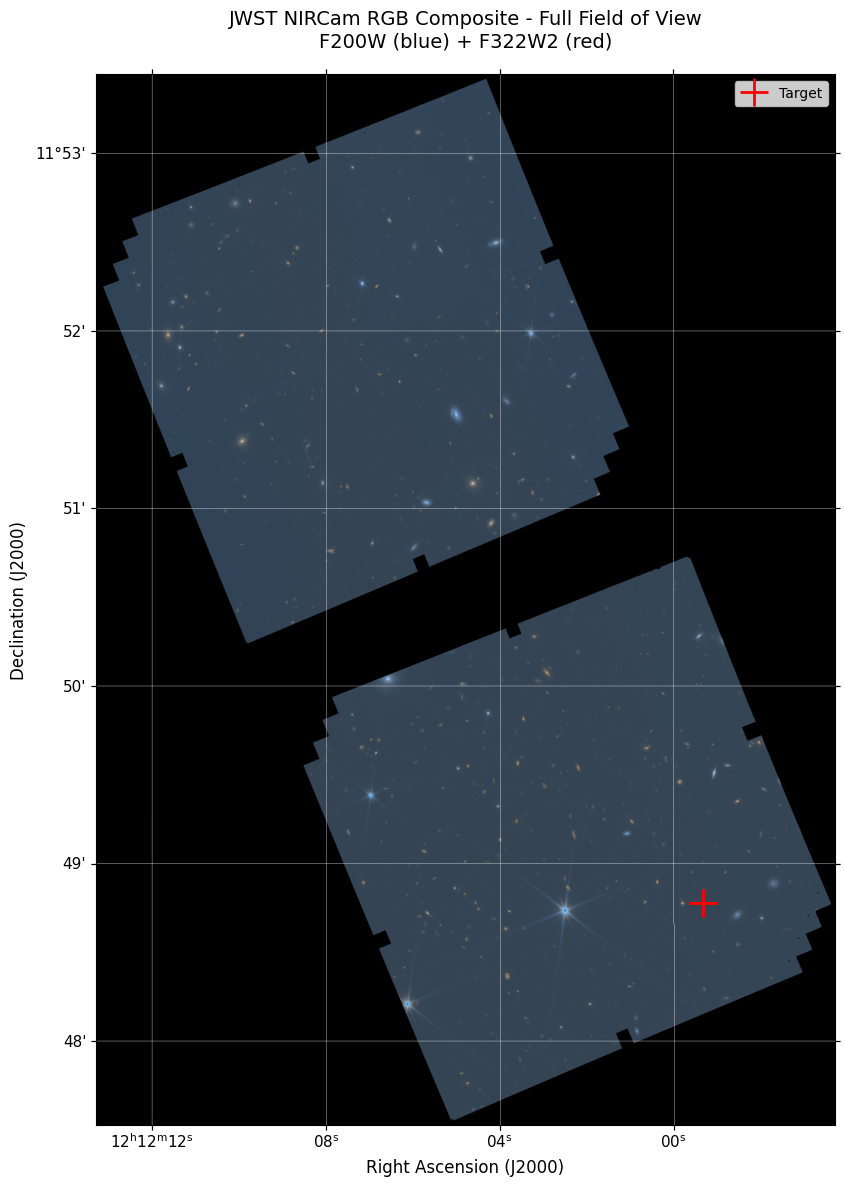

In [10]:
# Create figure with WCS projection
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection=wcs_obj)

# Display RGB image
ax.imshow(rgb_full, origin='lower')

# Add labels and grid
ax.set_title('JWST NIRCam RGB Composite - Full Field of View\nF200W (blue) + F322W2 (red)', 
             fontsize=14, pad=20)
ax.set_xlabel('Right Ascension (J2000)', fontsize=12)
ax.set_ylabel('Declination (J2000)', fontsize=12)
ax.coords.grid(True, color='white', ls='solid', alpha=0.5, lw=0.5)

# Mark the target location
target_pix = wcs_obj.all_world2pix([[target_ra, target_dec]], 0)[0]
ax.plot(target_pix[0], target_pix[1], 'r+', markersize=20, markeredgewidth=2, 
        label='Target', transform=ax.get_transform('pixel'))
ax.legend(loc='upper right', fontsize=10)

plt.tight_layout()

# Save the image
output_path_full = os.path.join(output_dir, 'rgb_full_fov.png')
# plt.savefig(output_path_full, dpi=300, bbox_inches='tight')
print(f"\n✓ Full FoV RGB image saved to: {output_path_full}")

plt.show()

## Step 7: Create Zoomed RGB Image Around Target

### 7a. Calculate Target Position and Cutout Region

In [11]:
# Convert target RA/Dec to pixel coordinates
target_pix = wcs_obj.all_world2pix([[target_ra, target_dec]], 0)[0]
center_x, center_y = target_pix

print(f"Target pixel coordinates: x = {center_x:.2f}, y = {center_y:.2f}")

# Calculate cutout region size in pixels
half_size_pixels = int(np.round((zoom_region_size / 2.0) / pixel_scale))

# Define pixel boundaries for cutout
xmin = int(np.round(center_x)) - half_size_pixels
xmax = int(np.round(center_x)) + half_size_pixels
ymin = int(np.round(center_y)) - half_size_pixels
ymax = int(np.round(center_y)) + half_size_pixels

print(f"\nZoom region:")
print(f"  Size: {zoom_region_size}″ × {zoom_region_size}″")
print(f"  Pixel size: {2*half_size_pixels} × {2*half_size_pixels} pixels")
print(f"  Cutout bounds: x=[{xmin}:{xmax}], y=[{ymin}:{ymax}]")

Target pixel coordinates: x = 6842.68, y = 2508.48

Zoom region:
  Size: 10.0″ × 10.0″
  Pixel size: 334 × 334 pixels
  Cutout bounds: x=[6676:7010], y=[2341:2675]


### 7b. Extract Cutout Regions from Each Channel

In [12]:
# Extract cutout regions
red_crop = red_channel[ymin:ymax, xmin:xmax]
green_crop = green_channel[ymin:ymax, xmin:xmax]
blue_crop = blue_channel[ymin:ymax, xmin:xmax]

print(f"✓ Cutout regions extracted")
print(f"  Cutout shape: {red_crop.shape}")

✓ Cutout regions extracted
  Cutout shape: (334, 334)


### 7c. Apply ZScale Normalization

Use ZScale (DS9-like) normalization for better contrast in the zoomed region.

In [13]:
# Apply ZScale normalization (similar to DS9)
zscale = ZScaleInterval()

red_scaled = np.clip(zscale(red_crop), 0, 1)
green_scaled = np.clip(zscale(green_crop), 0, 1)
blue_scaled = np.clip(zscale(blue_crop), 0, 1)

# Combine into RGB image
rgb_zoomed = np.dstack((red_scaled, green_scaled, blue_scaled))

print("✓ ZScale normalization applied")
print(f"  RGB zoom image shape: {rgb_zoomed.shape}")

✓ ZScale normalization applied
  RGB zoom image shape: (334, 334, 3)


### 7d. Display and Save Zoomed RGB Image with Overlays

Overlay box:
  Size: 3.0″ × 3.0″ (100.0 × 100.0 pixels)
  Position angle: 423.27°

✓ Zoomed RGB image saved to: data/06779/i2d/rgb_zoomed.png


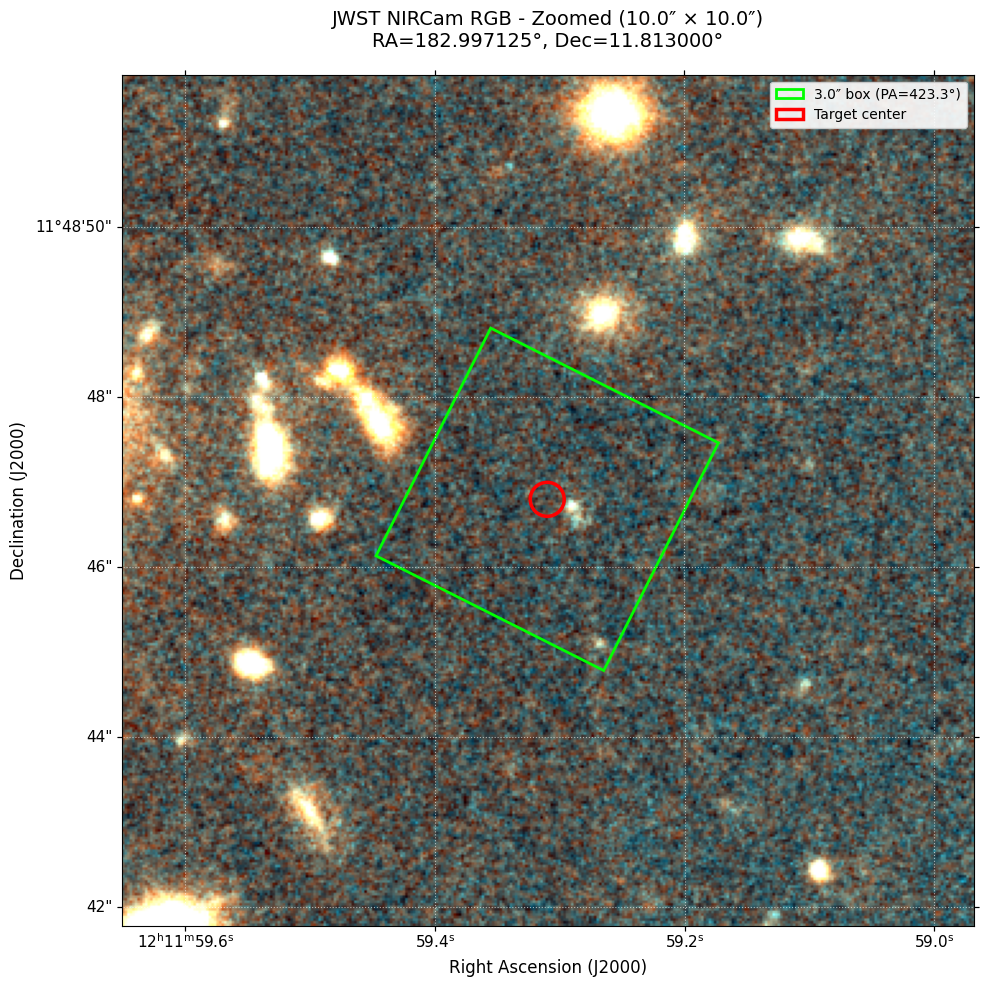

In [14]:
# Calculate overlay box parameters
box_size_pixels = overlay_box_size / pixel_scale
half_box_pixels = box_size_pixels / 2.0
box_lower_left = (center_x - half_box_pixels, center_y - half_box_pixels)

print(f"Overlay box:")
print(f"  Size: {overlay_box_size}″ × {overlay_box_size}″ ({box_size_pixels:.1f} × {box_size_pixels:.1f} pixels)")
print(f"  Position angle: {overlay_box_pa:.2f}°")

# Create figure
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection=wcs_obj)

# Display zoomed RGB image
extent = [xmin, xmax, ymin, ymax]
ax.imshow(rgb_zoomed, origin='lower', extent=extent)

# Add title and labels
ax.set_title(f'JWST NIRCam RGB - Zoomed ({zoom_region_size}″ × {zoom_region_size}″)\n'
             f'RA={target_ra:.6f}°, Dec={target_dec:.6f}°', 
             fontsize=14, pad=20)
ax.set_xlabel('Right Ascension (J2000)', fontsize=12)
ax.set_ylabel('Declination (J2000)', fontsize=12)

# Add coordinate grid
ax.coords.grid(True, color='white', ls='dotted', alpha=0.6, lw=0.8)

# Overlay: Rotated box (e.g., galaxy aperture)
rect = patches.Rectangle(
    box_lower_left, 
    box_size_pixels, 
    box_size_pixels,
    linewidth=2, 
    edgecolor='lime', 
    facecolor='none',
    transform=ax.get_transform('pixel'), 
    angle=overlay_box_pa, 
    rotation_point='center',
    label=f'{overlay_box_size}″ box (PA={overlay_box_pa:.1f}°)'
)
ax.add_patch(rect)

# Overlay: Target location marker
target_marker = patches.Circle(
    (center_x, center_y), 
    radius=0.2 / pixel_scale,  # 0.2" radius
    edgecolor='red', 
    facecolor='none',
    linewidth=2.5,
    transform=ax.get_transform('pixel'),
    label='Target center'
)
ax.add_patch(target_marker)

# Add legend
ax.legend(loc='upper right', fontsize=10, framealpha=0.9)

plt.tight_layout()

# Save zoomed image
output_path_zoom = os.path.join(output_dir, 'rgb_zoomed.png')
# plt.savefig(output_path_zoom, dpi=400, bbox_inches='tight')
print(f"\n✓ Zoomed RGB image saved to: {output_path_zoom}")

plt.show()

## Summary

This notebook has created:

1. **Full FoV RGB Image**: `rgb_full_fov.png`
   - Shows the entire NIRCam field of view
   - Uses Lupton algorithm for balanced dynamic range
   - Marks the target location

2. **Zoomed RGB Image**: `rgb_zoomed.png`
   - Centered on your target coordinates
   - Uses ZScale normalization for enhanced detail
   - Includes overlay box and target marker

### Customization Tips:

- **Adjust brightness/contrast**: Modify `lupton_stretch` and `lupton_Q` in Step 2
- **Change zoom level**: Adjust `zoom_region_size` in Step 2
- **Modify overlays**: Update overlay parameters (box size, PA, colors) in Step 2
- **Alternative normalization**: Replace ZScale with AsinhStretch or ManualInterval for different scaling

### Next Steps:

- Use these RGB images for publications, presentations, or visual inspection
- Perform photometry or morphological analysis on the target
- Create multi-band SEDs using photometric measurements